### Subcategory Metrics: `piece-class` vs `piece-color`
Build functions to turn any learner or evaluation routine, and eventually any train-loop (via `fastai2.metrics`) into reporting where the difference mis-classification is occuring.

In [1]:
from fastai2.vision.all import *
import sys
sys.path.append('..')

In [6]:
%load_ext autoreload
%autoreload 2

from modules.trainutils import build_dl, piece_class_parse
from modules.trainutils import my_metrics, stratify_sample
from modules.trainutils import show_cf, piece_class_parse
from modules.trainutils import only_class_parse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
test_path = Path('../../../other-chess-data/regulation-test-2-easy/')
train_path = Path('../../../rf-chess-data/cropped_v1/')

n = 200
seed=42

test_dl = build_dl(test_path, n=None)

train_dl = ImageDataLoaders.from_name_func(
                train_path, 
                # get_image_files(train_path),
                stratify_sample(train_path, n=n, np_seed=seed),
                valid_pct=0.2, 
                seed=42,
                label_func=only_class_parse, 
                item_tfms=RandomResizedCrop(128, min_scale=0.5),
                batch_tfms=aug_transforms(),
                # num_workers=1, # turn on for debugging
)

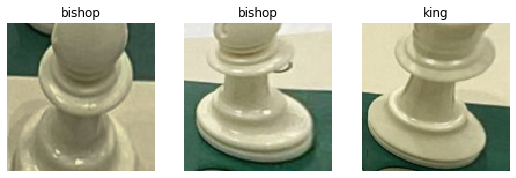

In [8]:
train_dl.show_batch(max_n=3)

In [9]:
train_dl.vocab

(#6) ['bishop','king','knight','pawn','queen','rook']

##### Build preds

In [24]:
# learn = load_learner('../models/expmod-b-1.pkl')
learn = load_learner('../models/stadard-piece-2.pkl')

In [25]:
good_test_dl = learn.dls.test_dl(get_image_files(test_path), 
                                 with_labels=True)

In [26]:
preds = learn.get_preds(dl=test_dl.train, with_loss=True)

In [27]:
good_test_dl

In [28]:
preds2 = learn.get_preds(dl=good_test_dl, with_loss=True)

In [29]:
len(preds[0]), len(preds2[0])

(162, 162)

In [30]:
p = preds

y_actual = p[1].tolist()
y_hat =    torch.argmax(p[0], dim=1).tolist()
y_loss =   p[2].tolist()

##### Build Transformers

In [31]:
d_fullclass = {i:v for i,v in enumerate(list(test_dl.vocab))}
d_fullclass

{0: 'black-bishop',
 1: 'black-king',
 2: 'black-knight',
 3: 'black-pawn',
 4: 'black-queen',
 5: 'black-rook',
 6: 'white-bishop',
 7: 'white-king',
 8: 'white-knight',
 9: 'white-pawn',
 10: 'white-queen',
 11: 'white-rook'}

In [32]:
d_colorclass = {'black':0, 'white':1}
d_piececlass = {'bishop':1, 'king':1, 'knight':2, 'pawn':3, 'queen':4,
                'rook':5}

In [33]:
def subcat_parse(class_label, color=False, piece=False):
    color_label, piece_label = class_label.split('-')
    color_ind = d_colorclass[color_label]
    piece_ind = d_piececlass[piece_label]
    if color: return color_ind
    if piece: return piece_ind
    return color_ind, piece_ind

In [34]:
y_actual_color = [subcat_parse(d_fullclass[e], color=True) for e in y_actual]
y_actual_piece = [subcat_parse(d_fullclass[e], piece=True) for e in y_actual]

y_hat_color = [subcat_parse(d_fullclass[e], color=True) for e in y_hat]
y_hat_piece = [subcat_parse(d_fullclass[e], piece=True) for e in y_hat]

##### Compare model perf

In [35]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_actual, y_hat)
acc_color = accuracy_score(y_actual_color, y_hat_color)
acc_piece = accuracy_score(y_actual_piece, y_hat_piece)

pd.DataFrame([acc, acc_color, acc_piece], 
             index=['overall', 'color', 'piece']).round(3)

,0
overall,0.117
color,0.537
piece,0.241


##### Verify the transformers